In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2ycbcr, ycbcr2rgb
# from google.colab import files
from ipywidgets import FileUpload
from IPython.display import display

In [2]:
# Function to display an image
def display_image(img, title="Image"):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
upload_widget = FileUpload(accept='image/*', multiple=False)

# Display the widget for file upload
display(upload_widget)

FileUpload(value=(), accept='image/*', description='Upload')

In [3]:
# Check if a file has been uploaded
if upload_widget.value:
    # Get the uploaded image data (this is a tuple)
    uploaded_image_data = upload_widget.value[0]  # Access the first (and only) file if multiple=False
    
    # Convert the uploaded file to numpy array
    input_image = np.asarray(bytearray(uploaded_image_data['content']), dtype=np.uint8)
    input_image = cv2.imdecode(input_image, cv2.IMREAD_COLOR)  # Decode as color image

    # Ensure the image was loaded correctly
    if input_image is None:
        print("Error: Could not read the image!")
    else:
        print("Image loaded successfully:", input_image.shape)
        
        # Store original dimensions
        original_height, original_width = input_image.shape[:2]
        
        # Display the original image
        plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image ({original_width}x{original_height})")
        plt.axis('off')
        plt.show()
else:
    print("No image uploaded yet. Please upload an image.")


No image uploaded yet. Please upload an image.


In [4]:
# Display the input image
cv2.imwrite("input.png", input_image)
display_image(input_image, "Input Image")

NameError: name 'input_image' is not defined

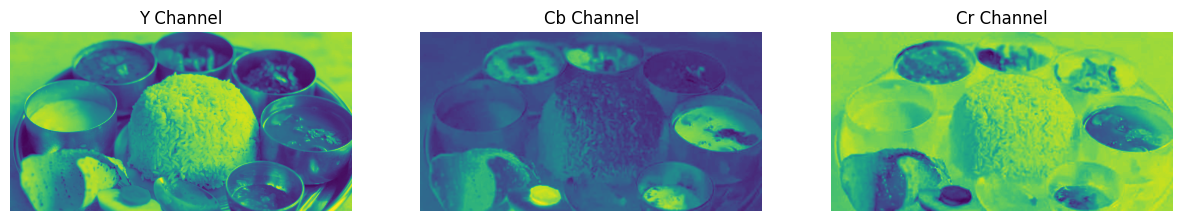

In [ ]:
# Step 2: Isolate the color information
def rgb_to_ycbcr_manual(image):
    R = image[:, :, 0].astype(float)
    G = image[:, :, 1].astype(float)
    B = image[:, :, 2].astype(float)

    # Apply the YCbCr conversion formula
    Y = (0.299 * R + 0.587 * G + 0.114 * B)
    Cb = 128 + (-0.168736 * R - 0.331264 * G + 0.5 * B)
    Cr = 128 + (0.5 * R - 0.418688 * G - 0.081312 * B)

    # Clip values to be in range [0, 255]
    Y = np.clip(Y, 0, 255)
    Cb = np.clip(Cb, 0, 255)
    Cr = np.clip(Cr, 0, 255)

    return Y, Cb, Cr

# Convert input image to YCbCr manually
Y, Cb, Cr = rgb_to_ycbcr_manual(input_image)

# Display Y, Cb, Cr channels separately
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(Y)  # Y channel should look like a grayscale image
plt.title("Y Channel")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Cb)  # Cb should highlight blue-related features
plt.title("Cb Channel")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Cr)  # Cr should highlight red-related features
plt.title("Cr Channel")
plt.axis('off')

plt.show()


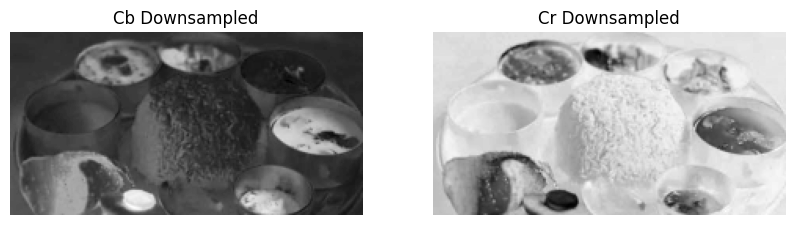

In [ ]:
# Step 3: Throw away some color information
def downsample(channel, factor=4):
    height, width = channel.shape
    new_height, new_width = height // factor, width // factor
    
    # Reshape into 4D array and average over last two axes
    downsampled = channel[:new_height * factor, :new_width * factor]  # Ensure divisibility
    downsampled = downsampled.reshape(new_height, factor, new_width, factor).mean(axis=(1, 3))
    
    return downsampled

# Apply optimized downsampling
Cb_downsampled = downsample(Cb)
Cr_downsampled = downsample(Cr)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(Cb_downsampled, cmap="gray")
plt.title("Cb Downsampled")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Cr_downsampled, cmap="gray")
plt.title("Cr Downsampled")
plt.axis('off')

plt.show()


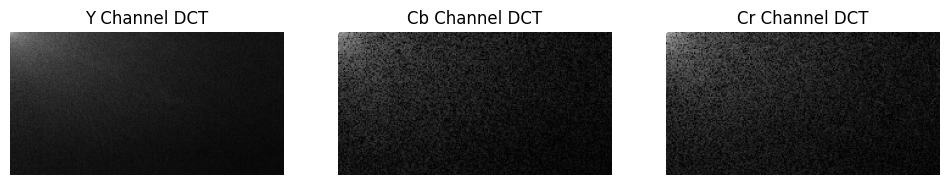

In [ ]:
# Step 4: Convert to the frequency domain (DCT)
# Define DCT and IDCT using OpenCV's built-in functions
def dct_matrix(N):
    """
    Generate the 1D DCT matrix for size N.
    """
    c = np.sqrt(2 / N)
    D = np.zeros((N, N))
    
    for u in range(N):
        for x in range(N):
            if u == 0:
                D[u, x] = np.sqrt(1 / N)
            else:
                D[u, x] = c * np.cos((np.pi / N) * (x + 0.5) * u)
    
    return D

def dct_2d(block):
    """
    Apply the 2D Discrete Cosine Transform (DCT) on an N x N block using matrix multiplication.
    :param block: 2D numpy array (image block)
    :return: DCT-transformed 2D block
    """
    N, M = block.shape  # Get the dimensions of the block
    
    # Generate the DCT matrix for both row and column size
    D_row = dct_matrix(N)
    D_col = dct_matrix(M)
    
    # Apply DCT row-wise and column-wise
    dct_block = np.dot(np.dot(D_row, block), D_col.T)
    
    return dct_block

def idct_2d(block):
    """
    Apply the 2D Inverse Discrete Cosine Transform (IDCT) on an N x N block using matrix multiplication.
    :param block: 2D numpy array (DCT coefficients)
    :return: Reconstructed image block
    """
    N, M = block.shape  # Get the dimensions of the block
    
    # Generate the DCT matrix for both row and column size
    D_row = dct_matrix(N)
    D_col = dct_matrix(M)
    
    # Apply IDCT row-wise and column-wise
    idct_block = np.dot(np.dot(D_row.T, block), D_col)
    
    return idct_block


# Apply DCT to Y, Cb, Cr channels (assuming they are already separated)
Y_dct = dct_2d(Y)
Cb_dct = dct_2d(Cb_downsampled)
Cr_dct = dct_2d(Cr_downsampled)

# Display the DCT-transformed blocks
plt.figure(figsize=(12, 6))

# Y channel DCT
plt.subplot(1, 3, 1)
plt.imshow(np.log(np.abs(Y_dct) + 1), cmap='gray')  # Log scale to visualize both small and large values
plt.title("Y Channel DCT")
plt.axis('off')

# Cb channel DCT
plt.subplot(1, 3, 2)
plt.imshow(np.log(np.abs(Cb_dct) + 1), cmap='gray')  # Log scale to visualize both small and large values
plt.title("Cb Channel DCT")
plt.axis('off')

# Cr channel DCT
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(Cr_dct) + 1), cmap='gray')  # Log scale to visualize both small and large values
plt.title("Cr Channel DCT")
plt.axis('off')

plt.show()


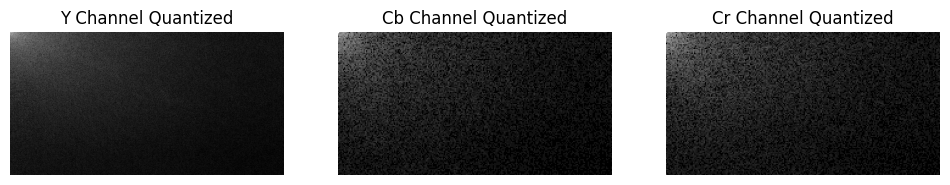

In [ ]:
# Step 5: Quantization (quality slider)
def quantize(block, quality):
    """
    Perform quantization on the DCT block using a simple quantization matrix.
    :param block: 2D numpy array of DCT coefficients
    :param quality: Scalar value controlling the level of quantization (higher = less quantization)
    :return: Quantized DCT block
    """
    Q = np.ones(block.shape) * quality  # Create quantization matrix
    return np.round(block / Q) * Q  # Apply quantization

# Set the quality factor for quantization (you can experiment with this value)
quality = 1

# Quantize the DCT-transformed channels
Y_quantized = quantize(Y_dct, quality)
Cb_quantized = quantize(Cb_dct, quality)
Cr_quantized = quantize(Cr_dct, quality)

# Display the quantized DCT blocks
plt.figure(figsize=(12, 6))

# Y channel Quantized
plt.subplot(1, 3, 1)
plt.imshow(np.log(np.abs(Y_quantized) + 1), cmap='gray')  # Log scale for better visualization
plt.title("Y Channel Quantized")
plt.axis('off')

# Cb channel Quantized
plt.subplot(1, 3, 2)
plt.imshow(np.log(np.abs(Cb_quantized) + 1), cmap='gray')  # Log scale for better visualization
plt.title("Cb Channel Quantized")
plt.axis('off')

# Cr channel Quantized
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(Cr_quantized) + 1), cmap='gray')  # Log scale for better visualization
plt.title("Cr Channel Quantized")
plt.axis('off')

plt.show()

In [ ]:
# Step 6: Lossless data compression (simulate using np.savez for now)
np.savez("compressed_data.npz", Y=Y_quantized, Cb=Cb_quantized, Cr=Cr_quantized)


In [ ]:
# Decoding
# Step 7: Decompression
compressed_data = np.load("compressed_data.npz")

# Extract the individual channels (Y, Cb, Cr) from the compressed data
Y_decompressed = compressed_data["Y"]
Cb_decompressed = compressed_data["Cb"]
Cr_decompressed = compressed_data["Cr"]

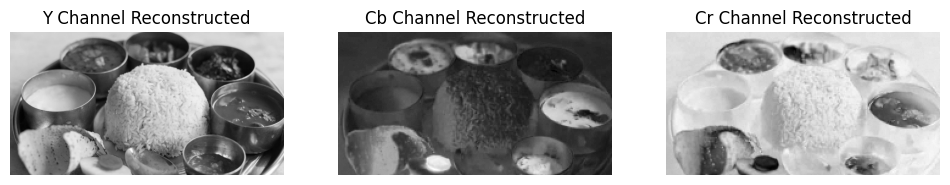

In [ ]:
# Step 8: Reconstruction from quantized data
Y_reconstructed = idct_2d(Y_decompressed)
Cb_reconstructed = idct_2d(Cb_decompressed)
Cr_reconstructed = idct_2d(Cr_decompressed)

plt.figure(figsize=(12, 6))

# Y channel reconstruction
plt.subplot(1, 3, 1)
plt.imshow(Y_reconstructed, cmap='gray')
plt.title("Y Channel Reconstructed")
plt.axis('off')

# Cb channel reconstruction
plt.subplot(1, 3, 2)
plt.imshow(Cb_reconstructed, cmap='gray')
plt.title("Cb Channel Reconstructed")
plt.axis('off')

# Cr channel reconstruction
plt.subplot(1, 3, 3)
plt.imshow(Cr_reconstructed, cmap='gray')
plt.title("Cr Channel Reconstructed")
plt.axis('off')

plt.show()

In [ ]:
def resize_channel_to_match(y_channel, channel_to_resize):
    """
    Manually resize the given channel (Cb or Cr) to match the height and width of the Y channel
    using nearest neighbor interpolation for resizing.
    """
    new_height, new_width = y_channel.shape
    resized_channel = cv2.resize(channel_to_resize, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    
    return resized_channel

# Apply the resizing for Cb and Cr to match the Y channel resolution (3840, 5760)
Cb_resized = resize_channel_to_match(Y_reconstructed, Cb_reconstructed)
Cr_resized = resize_channel_to_match(Y_reconstructed, Cr_reconstructed)

# Manually merge the channels (Y, Cb, Cr)
def merge_ycbcr(Y, Cb, Cr):
    """
    Manually merge Y, Cb, and Cr channels into a single YCbCr image.
    Ensures the output has shape (height, width, 3).
    """
    return np.stack((Y, Cb, Cr), axis=-1)

# Merge Y, Cb, Cr channels after resizing
reconstructed_ycbcr = merge_ycbcr(Y_reconstructed, Cb_resized, Cr_resized)

# To visualize or further process the image, convert it to RGB
# For example, using a manual RGB conversion function if needed:
# reconstructed_rgb = ycbcr2rgb_manual(reconstructed_ycbcr)


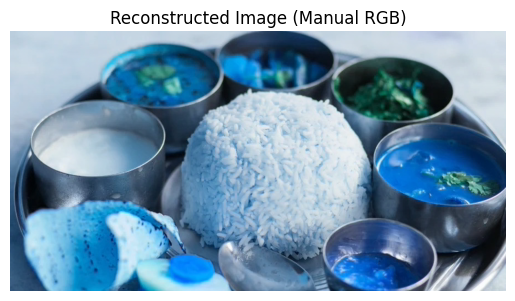

In [ ]:
# Step 10: Fill in missing color information
def ycbcr2rgb(ycbcr_image):
    """
    Convert a YCbCr image back to RGB using manual formulas.
    :param ycbcr_image: 3D numpy array of shape (height, width, 3) representing the YCbCr image.
    :return: RGB image in the range [0, 255] as a 3D numpy array.
    """
    # Extract Y, Cb, Cr channels
    Y = ycbcr_image[:, :, 0]
    Cb = ycbcr_image[:, :, 1]
    Cr = ycbcr_image[:, :, 2]
    
    # Apply the YCbCr to RGB conversion formula
    R = Y + 1.402 * (Cr - 128)
    G = Y - 0.344136 * (Cb - 128) - 0.714136 * (Cr - 128)
    B = Y + 1.772 * (Cb - 128)

    # Stack the R, G, B channels to form the final RGB image
    rgb_image = np.stack((R, G, B), axis=-1)

    # Clip the values to the valid range [0, 255] and convert to uint8
    rgb_image = np.clip(rgb_image, 0, 255).astype(np.uint8)
    
    return rgb_image

# Convert reconstructed YCbCr back to RGB using manual formula
output_image = ycbcr2rgb(reconstructed_ycbcr)

# Display the output image
plt.imshow(output_image)
plt.title("Reconstructed Image (Manual RGB)")
plt.axis('off')
plt.show()


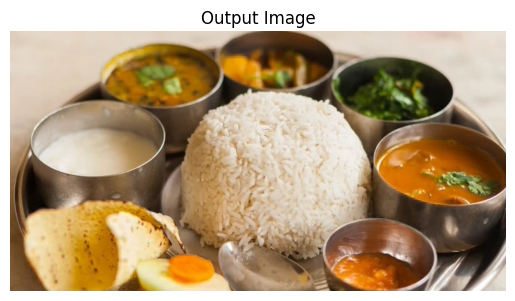

In [ ]:
# Display the output image
display_image(output_image, "Output Image")


In [ ]:
# Save the output image
cv2.imwrite("output.png", output_image)


True

In [194]:
# Save and download the compressed image
# output_filename = 'output.jpg'
# cv2.imwrite(output_filename, cv2.cvtColor(output_image, cv2.COLOR_YCrCb2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), 50])
# files.download(output_filename)